In [233]:
import pandas as pd
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from itertools import product
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.ops import MLP
from torch import optim


from IPython.display import clear_output

In [234]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


# Train Validation Split

In [235]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [236]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


# Outliers

<Axes: >

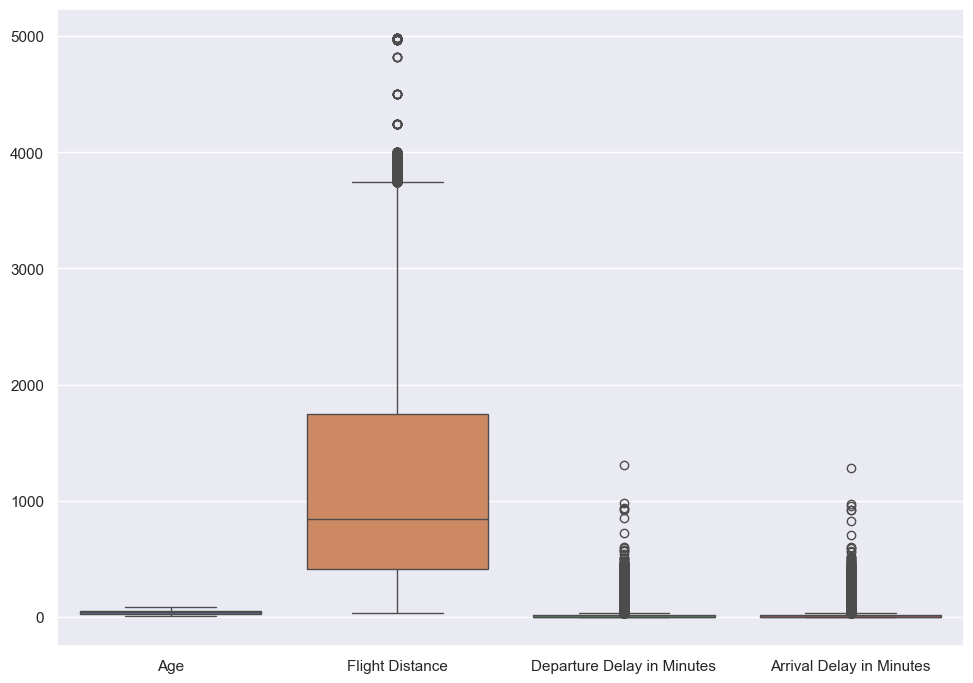

In [237]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=train_df[cols])

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76132, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


<Axes: >

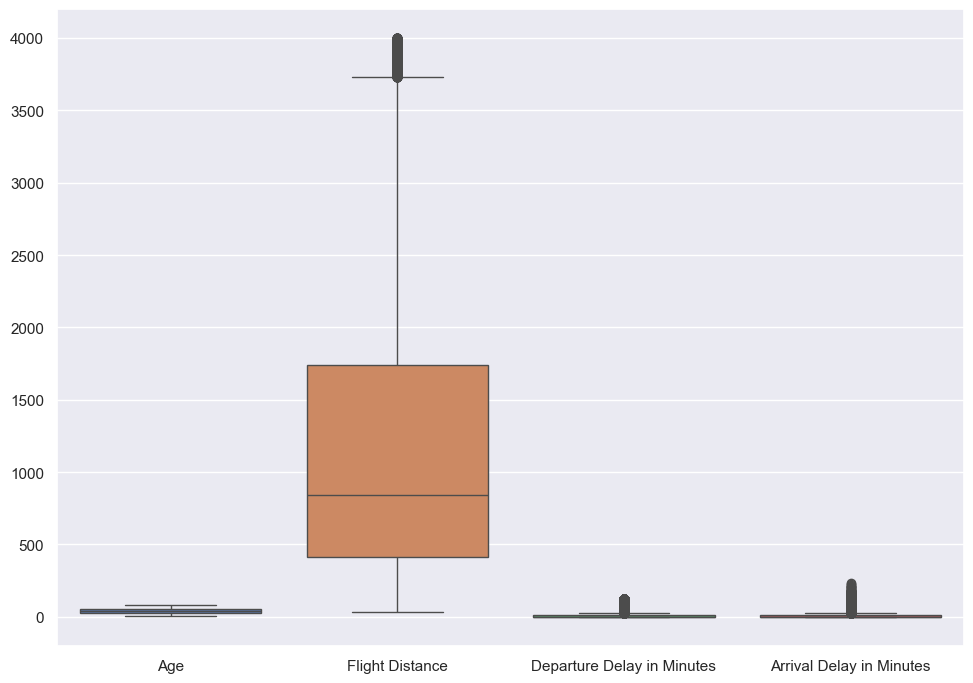

In [238]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)
        
    
print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

sns.boxplot(data=train_df[cols])

# Enconding

## Class Variable

In [239]:
classes_dict = {
    'neutral or dissatisfied': 0,
    'satisfied': 1
}
def ord_encode(x):
    return classes_dict[x]

dec_class = 'satisfaction'
print('Before Encoding: ', train_df[dec_class].values)
train_df[dec_class] = train_df[dec_class].map(ord_encode)
validation_df[dec_class] = validation_df[dec_class].map(ord_encode)
print('After Encoding: ', train_df[dec_class].values)


Before Encoding:  ['neutral or dissatisfied' 'satisfied' 'neutral or dissatisfied' ...
 'neutral or dissatisfied' 'neutral or dissatisfied'
 'neutral or dissatisfied']
After Encoding:  [0 1 0 ... 0 0 0]


## One Hot Enconding

In [240]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,True,True,False
1,False,False,False
2,False,True,True
3,False,False,False
4,False,True,False
...,...,...,...
76127,False,True,True
76128,True,False,False
76129,True,True,False
76130,False,True,True


## Ordinal Enconding

In [241]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].map(ord_encode)
validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].map(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Eco']
 ['Business']
 ['Eco']
 ...
 ['Eco']
 ['Eco']
 ['Eco']]
After Encoding:  [[0]
 [2]
 [0]
 ...
 [0]
 [0]
 [0]]


# Correlation

## Continuous Variables

Needs to be done before Binning

<Axes: >

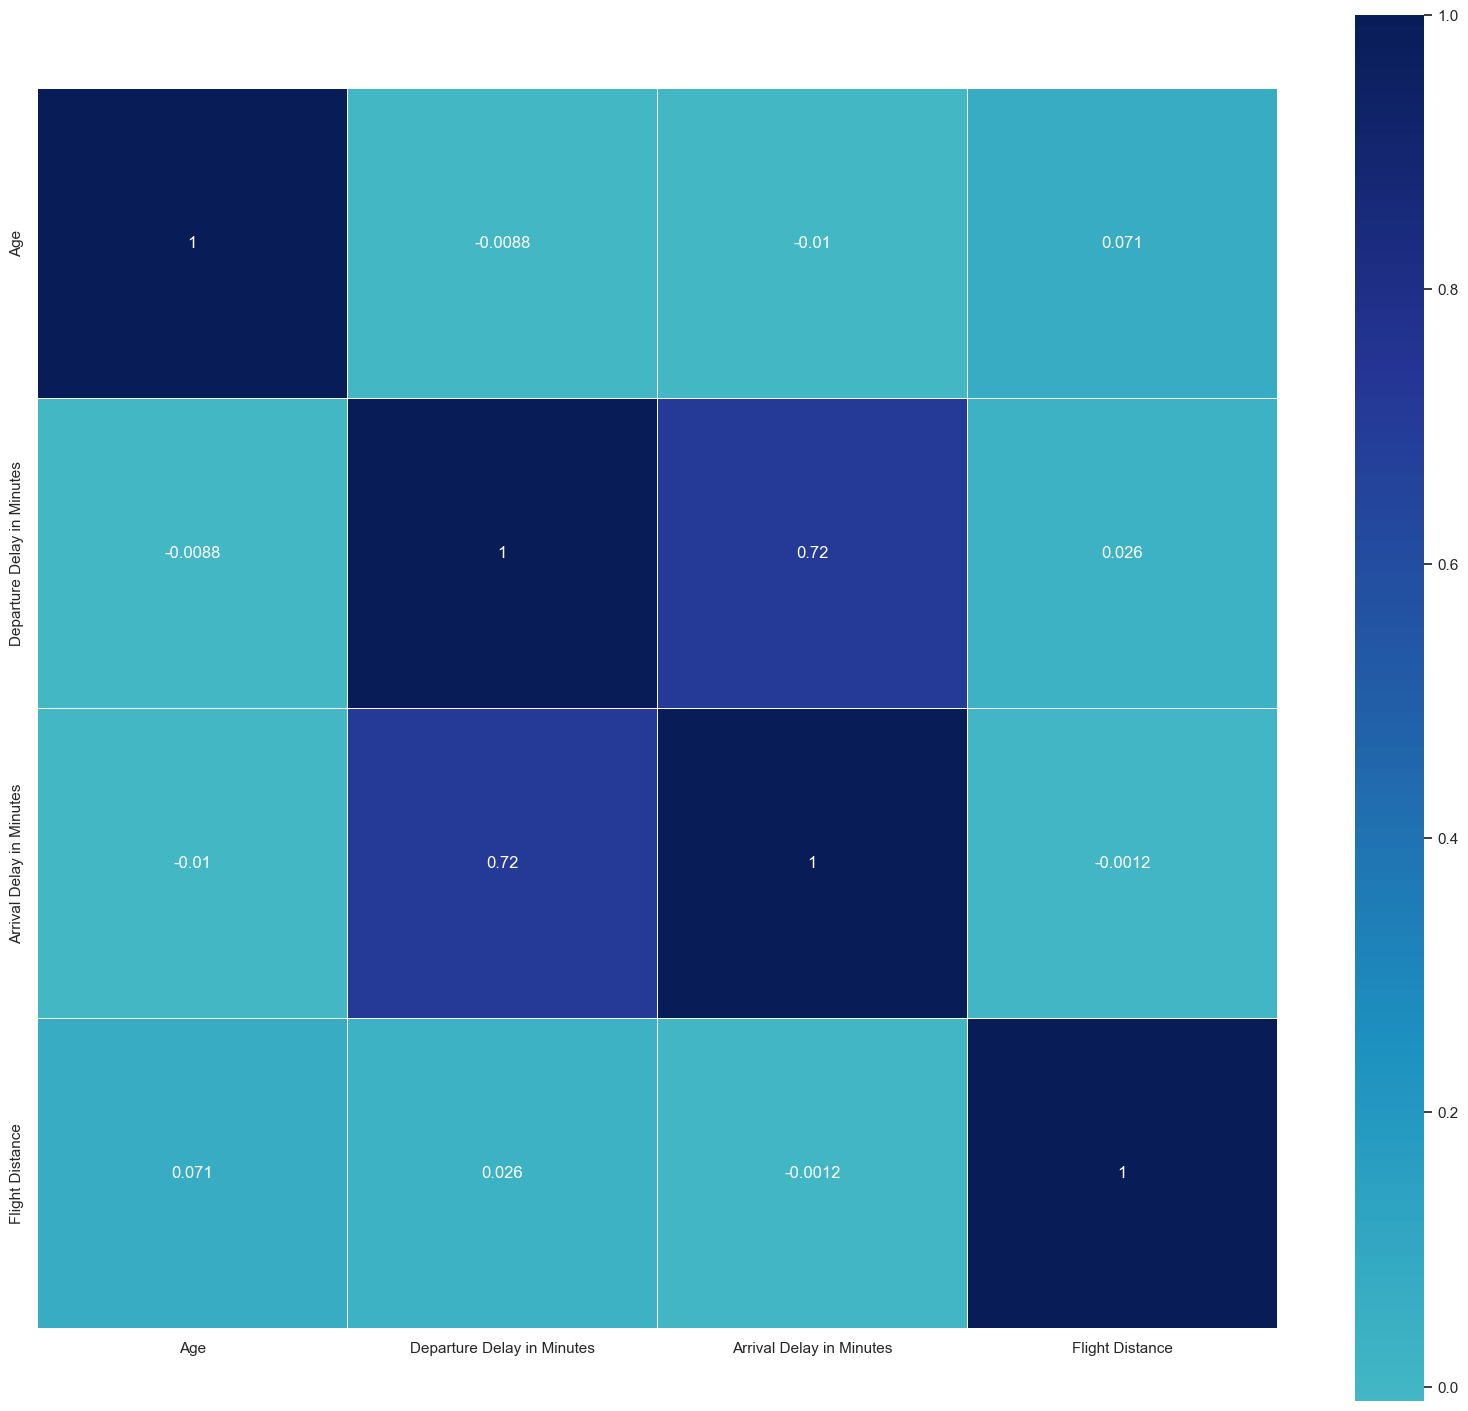

In [242]:
columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

corr = train_df[columns].corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)

In [243]:
corr

,Age,Departure Delay in Minutes,Arrival Delay in Minutes,Flight Distance
Age,1.000000,-0.008824,-0.010339,0.071363
Departure Delay in Minutes,-0.008824,1.000000,0.717535,0.026443
Arrival Delay in Minutes,-0.010339,0.717535,1.000000,-0.001236
Flight Distance,0.071363,0.026443,-0.001236,1.000000


## Categorical Variables (Chi Squared Test)

In [244]:
columns = ['Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction', 'Type of Travel_Personal Travel', 'Gender_Male',
       'Customer Type_disloyal Customer']

print('Shape Before dropna: ', train_df[columns].shape)
df_corr = train_df[columns].dropna()
print('Shape After dropna: ', df_corr.shape)

cat_var_prod = list(product(columns,columns, repeat = 1))

result = []
for i in cat_var_prod:
       if i[0] != i[1]:
              result.append((i[0],i[1],list(stats.chi2_contingency(pd.crosstab(df_corr[i[0]], df_corr[i[1]])))[1]))
result

Shape Before dropna:  (76132, 19)
Shape After dropna:  (76132, 19)


[('Class', 'Inflight wifi service', 0.0),
 ('Class', 'Departure/Arrival time convenient', 0.0),
 ('Class', 'Ease of Online booking', 0.0),
 ('Class', 'Gate location', 0.0),
 ('Class', 'Food and drink', 6.771406347319683e-172),
 ('Class', 'Online boarding', 0.0),
 ('Class', 'Seat comfort', 0.0),
 ('Class', 'Inflight entertainment', 0.0),
 ('Class', 'On-board service', 0.0),
 ('Class', 'Leg room service', 0.0),
 ('Class', 'Baggage handling', 0.0),
 ('Class', 'Checkin service', 0.0),
 ('Class', 'Inflight service', 0.0),
 ('Class', 'Cleanliness', 0.0),
 ('Class', 'satisfaction', 0.0),
 ('Class', 'Type of Travel_Personal Travel', 0.0),
 ('Class', 'Gender_Male', 0.00179073585976005),
 ('Class', 'Customer Type_disloyal Customer', 2.2399171700453005e-249),
 ('Inflight wifi service', 'Class', 0.0),
 ('Inflight wifi service', 'Departure/Arrival time convenient', 0.0),
 ('Inflight wifi service', 'Ease of Online booking', 0.0),
 ('Inflight wifi service', 'Gate location', 0.0),
 ('Inflight wifi ser

<Axes: >

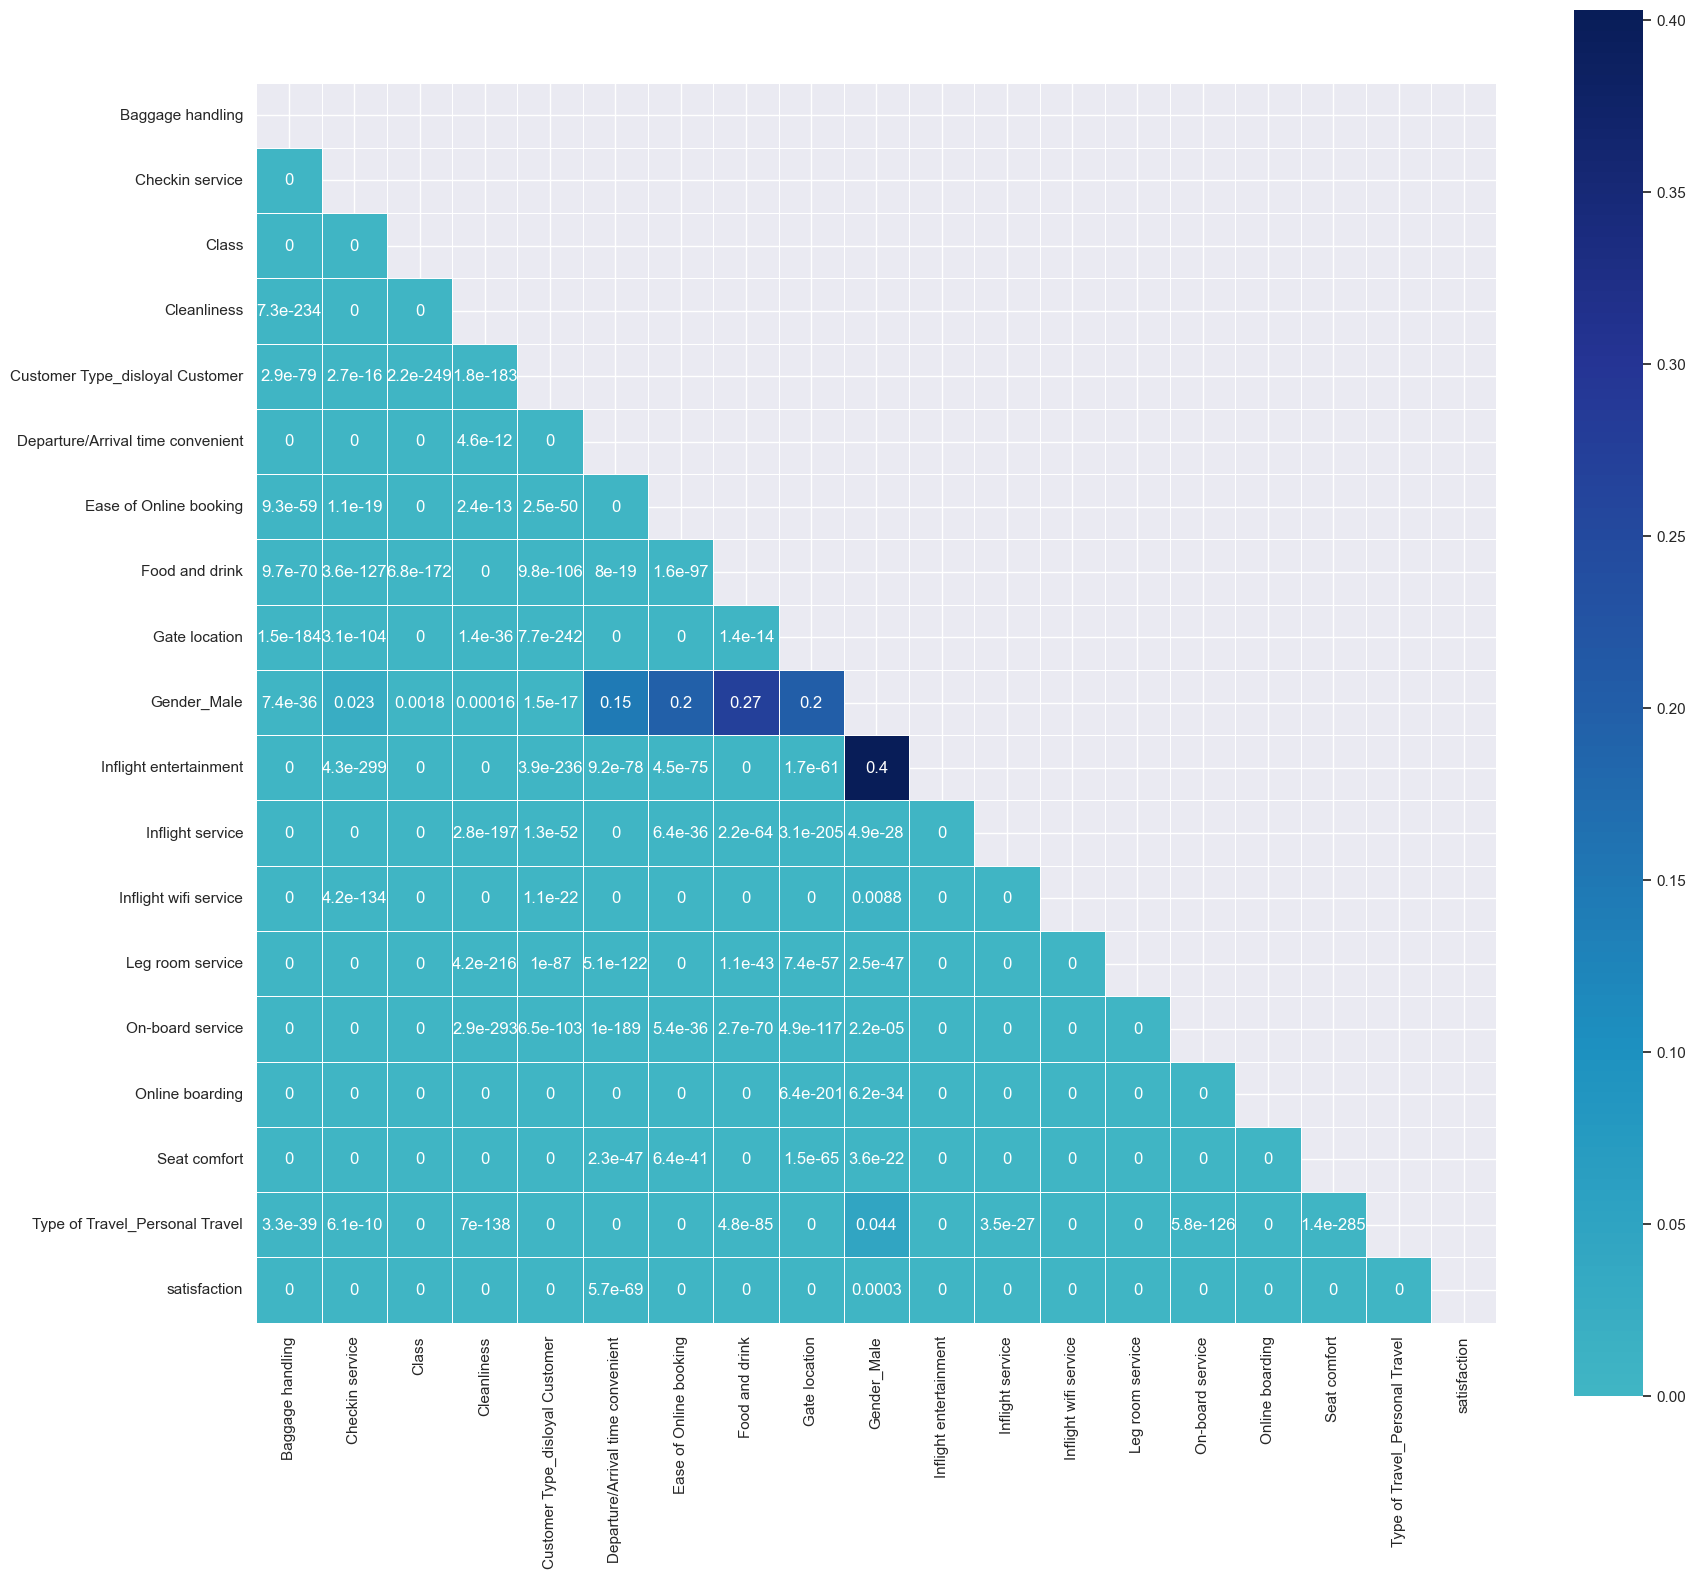

In [245]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 
                                                       'corr'])

chi_test_output = chi_test_output.pivot(index='var1', columns='var2', values='corr')
chi_test_output =  chi_test_output.rename_axis(None, axis=1) 
chi_test_output =  chi_test_output.rename_axis(None, axis=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(chi_test_output, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chi_test_output, annot = True, mask=mask, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)


# Binning

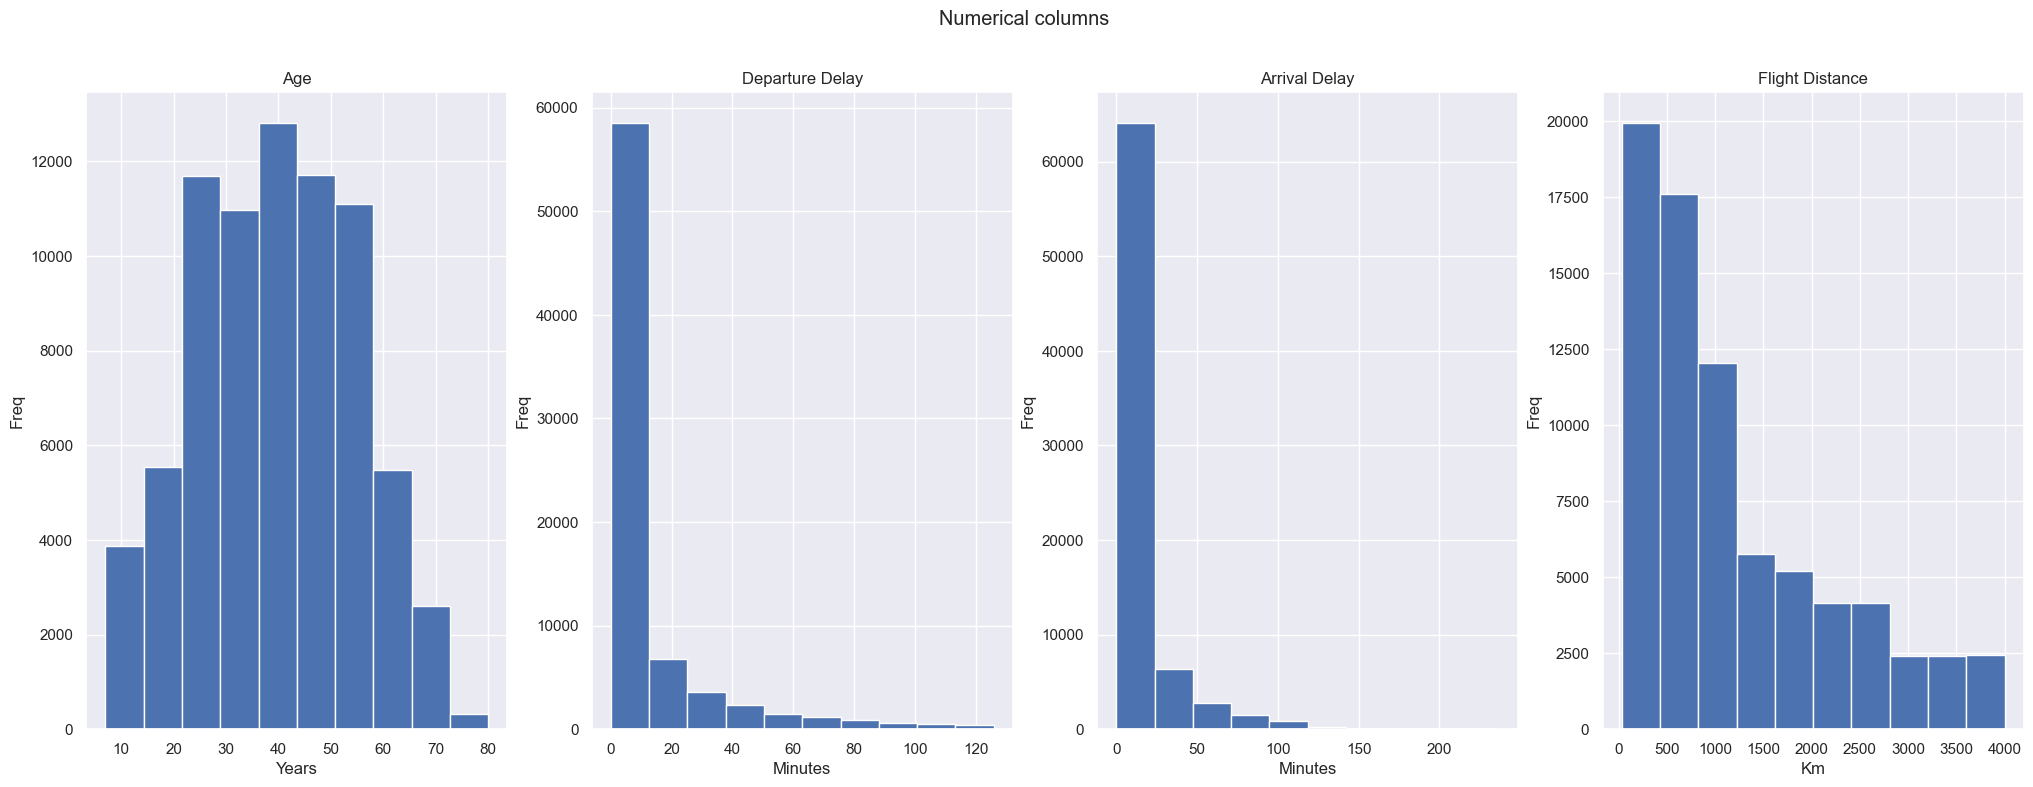

In [246]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'])

ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'])

ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'])

ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'])

plt.show()

In [247]:
def dist_binning(column: str):
    # 4 bins
    boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)
    
    print(f'{column} boundary to split: ', boundary)

    bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
    print('Bin means: ', bins_means)

    def binnign_method(age) -> int:

        if np.isnan(age):
            return np.nan
        
        if age < boundary:
            return bins_means[0]
        
        if age < 2*boundary:
            return bins_means[1]
        
        if age < 3*boundary:
            return bins_means[2]
        
        if age < 4*boundary:
            return bins_means[3]

    print(f'{column} before binning: ', train_df[column].head(10))
    train_df[column] = train_df[column].map(binnign_method)
    validation_df[column] = validation_df[column].map(binnign_method)
    print(f'{column} After binning: ', train_df[column].head(10))


### Age

In [248]:
dist_binning(column='Age')

Age boundary to split:  19
Bin means:  [14, 29, 47, 63]
Age before binning:  0    59
1    59
2    43
3    41
4    59
5    51
6    62
7    12
8    10
9    23
Name: Age, dtype: int64
Age After binning:  0    63.0
1    63.0
2    47.0
3    47.0
4    63.0
5    47.0
6    63.0
7    14.0
8    14.0
9    29.0
Name: Age, dtype: float64


### Departure Delay

In [249]:
dist_binning(column='Departure Delay in Minutes')

Departure Delay in Minutes boundary to split:  32
Bin means:  [4, 45, 78, 110]
Departure Delay in Minutes before binning:  0    58
1    13
2     0
3     0
4     0
5    33
6    31
7     1
8     0
9     4
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes After binning:  0    45
1     4
2     4
3     4
4     4
5    45
6     4
7     4
8     4
9     4
Name: Departure Delay in Minutes, dtype: int64


### Arrival Delay

In [250]:
dist_binning(column='Arrival Delay in Minutes')

Arrival Delay in Minutes boundary to split:  60
Bin means:  [7, 83, 135, 205]
Arrival Delay in Minutes before binning:  0    53.0
1    11.0
2     0.0
3     0.0
4     0.0
5    57.0
6    58.0
7     1.0
8     0.0
9     6.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes After binning:  0    7.0
1    7.0
2    7.0
3    7.0
4    7.0
5    7.0
6    7.0
7    7.0
8    7.0
9    7.0
Name: Arrival Delay in Minutes, dtype: float64


### Flight Distance

In [251]:
dist_binning(column='Flight Distance')

Flight Distance boundary to split:  993
Bin means:  [496, 1423, 2441, 3481]
Flight Distance before binning:  0     177
1     226
2     557
3     156
4    3091
5    1426
6    2994
7     547
8     323
9     255
Name: Flight Distance, dtype: int64
Flight Distance After binning:  0     496.0
1     496.0
2     496.0
3     496.0
4    3481.0
5    1423.0
6    3481.0
7     496.0
8     496.0
9     496.0
Name: Flight Distance, dtype: float64


In [252]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,75928.00000,76132.000000,75951.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,76132.000000,75916.000000,76132.000000
mean,39.97092,1.030487,1181.569999,2.734067,3.058215,2.759300,2.977092,3.211094,3.254072,3.445805,3.362896,3.388273,3.343233,3.627187,3.305325,3.647888,3.288157,10.659105,11.103377,0.434929
std,14.04649,0.962923,951.280569,1.328418,1.527865,1.398364,1.276830,1.328124,1.347895,1.316845,1.333747,1.287151,1.319151,1.184115,1.263894,1.173969,1.311603,19.993776,18.121490,0.495751
min,14.00000,0.000000,496.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,7.000000,0.000000
25%,29.00000,0.000000,496.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,7.000000,0.000000
50%,47.00000,1.000000,496.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,7.000000,0.000000
75%,47.00000,2.000000,1423.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,7.000000,1.000000
max,63.00000,2.000000,3481.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,110.000000,205.000000,1.000000


# Missing Values

In [253]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Age', 'Flight Distance', 'Arrival Delay in Minutes'], dtype='object')
Index([], dtype='object')


In [254]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')


Index([], dtype='object')

# Min Max Scaling

In [255]:
columns = ['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = MinMaxScaler()
f_scaler=scaler.fit(train_df[columns])

# Train
train_df[columns] = f_scaler.transform(train_df[columns])

# Validation
validation_df[columns] = f_scaler.transform(validation_df[columns])

# OverSampling

In [256]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 1]), ' not satisfied: ', len(y[y['satisfaction'] != 1]))
  print('satisfied: {:.2f}%'.format(len(y[y['satisfaction'] == 1])/len(y) * 100), ' not satisfied: {:.2f}%'.format(len(y[y['satisfaction'] != 1])/len(y) * 100), '\n')

In [257]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76132
satisfied:  33112  not satisfied:  43020
satisfied: 43.49%  not satisfied: 56.51% 

total:  86040
satisfied:  43020  not satisfied:  43020
satisfied: 50.00%  not satisfied: 50.00% 



In [258]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied: 43.33%  not satisfied: 56.67% 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied: 50.00%  not satisfied: 50.00% 



# Experimento com Modelos

In [259]:
# 5% do dataset para testar treinamento

X_train, _, y_train, _ = train_test_split(x_train_df, y_train_df, test_size=0.95, stratify=y_train_df['satisfaction'])
X_valid, _, y_valid, _ = train_test_split(x_validation_df, y_validation_df, test_size=0.95, stratify=y_validation_df['satisfaction'])

X_valid.shape, y_valid.shape

((1472, 22), (1472, 1))

In [260]:
def plot_confusion(y_true, y_pred, title):
 disp = ConfusionMatrixDisplay.from_predictions(
 y_true,
 y_pred,
 cmap=plt.cm.Blues,
 normalize=None,
 )
 disp.ax_.set_title(title)
 plt.show()

## MLP - Torch

In [261]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [262]:
def train(model, optimizer, loss_fn, train_dl, valid_dl, epochs, plot_loss = False):
  best_loss = np.infty

  model = model.to(device)
  best_model = model
  model.train()
  train_losses = []
  valid_losses = []

  for epoch in range(epochs):

    acc_loss = []

    for X, y in iter(train_dl):


      X = X.to(device)
      y = y.to(device)

      y_hat = model(X).softmax(dim=1)

      loss = loss_fn(y_hat, y)

      del X, y

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      acc_loss.append(loss.detach().cpu())

    train_losses.append(np.mean(acc_loss))

    acc_loss = []

    for X, y in valid_dl:
      X = X.to(device)
      y = y.to(device)
      y_hat = model(X).softmax(dim=1)
      loss = loss_fn(y_hat, y)
      acc_loss.append(loss.detach().cpu())

    valid_losses.append(np.mean(acc_loss))

    if valid_losses[-1] < best_loss:
      best_loss = valid_losses[-1]
      best_model = model

    if epoch % 250 == 0:
      print(f'Epoch: {epoch}/{epochs}', f'Best loss: {best_loss}')

    if plot_loss:
      clear_output(wait=True)

      plt.grid()

      plt.plot(train_losses, linestyle = '--', color = "orange", label = 'Train Losses')
      plt.plot(valid_losses, linestyle = '--', color = "blue", label = 'Validation Losses')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')

      plt.legend()

      plt.show()

  return best_model




In [263]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def aux(train_dl, valid_dl, activation_fn, hidden_layers, lr, dropout, reg):

  clf = MLP(in_channels=22, hidden_channels=hidden_layers, activation_layer=activation_fn, dropout=dropout)
  print(clf)
  clf.train()

  optimizer = optim.SGD(clf.parameters(), lr=lr, weight_decay=reg)
  loss_fn = torch.nn.CrossEntropyLoss()

  best_model = train(clf, optimizer, loss_fn, train_dl, valid_dl, epochs = 20000)

  best_model.eval()

  predicted_train = best_model(X_train_tensor.float().to(device)).argmax(dim=1).cpu().detach()
  predicted_valid = best_model(X_valid_tensor.float().to(device)).argmax(dim=1).cpu().detach()

  return best_model, (accuracy_score(y_valid_tensor, predicted_valid), recall_score(y_valid_tensor, predicted_valid, average='weighted'), precision_score(y_valid_tensor, predicted_valid, average='weighted'), f1_score(y_valid_tensor, predicted_valid, average='weighted'))

In [264]:
def grid_search(train_dl, valid_dl, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            model, scores = aux(train_dl, valid_dl, act, hl, lr, drp, reg)
            acc, recall, precision, f1 = scores
            if acc > best_acc:
                best_acc = acc
                best_model = model
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}; recall: {recall}; precision: {precision}; f1:{f1}\n')
  print(f"\n\nBest model args: {args}")
  return best_model

In [265]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [266]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64).ravel())

X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
y_valid_tensor = torch.tensor(y_valid.values.astype(np.int64).ravel())

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size = 256, shuffle = True, num_workers=2)

hidden_channels = [[5], [5, 10]]
actv_fns = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh]
learning_rates = [0.1, 0.01]
dropout = [0,0.1]
regularization = [0, 0.01]

best_model = grid_search(train_dl, valid_dl, actv_fns, hidden_channels, learning_rates, dropout, regularization)


PARAMETROS: F.Act.: <class 'torch.nn.modules.activation.ReLU'>; Layers: [5]; LR: 0.1; Dropout: 0; Reg: 0
MLP(
  (0): Linear(in_features=22, out_features=5, bias=True)
  (1): Dropout(p=0, inplace=False)
)
Epoch: 0/20000 Best loss: 1.4393324851989746


KeyboardInterrupt: 

# RF